In [2]:
!apt install chromium-browser
!pip install websocket-client

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-drivers cuda-license-10-2 cuda-npp-10-1
  cuda-npp-dev-10-1 cuda-nsight-10-1 cuda-nsight-compute-10-1
  cuda-nsight-systems-10-1 cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1
  cuda-nvjpeg-10-1 cuda-nvjpeg-dev-10-1 cuda-nvrtc-10-1 cuda-nvrtc-dev-10-1
  cuda-nvvp-10-1 default-jre dkms freeglut3 freeglut3-dev
  keyboard-configuration libargon2-0 libcap2 libcryptsetup12 libcublas10
  libdevmapper1.02.1 libfontenc1 libgtk2.0-0 libgtk2.0-common libidn11
  libip4tc0 libjansson4 libnvidia-cfg1-440 libnvidia-common-430
  libnvidia-common-440 libnvidia-decode-440 libnvidia-encode-440
  libnvidia-fbc1-440 libnvidia-gl-440 libnvidia-ifr1-440 libpam-systemd
  libpo

In [0]:
import websocket
import json

class ChromeDevToolsProtocolError(Exception):
    def __init__(self, error):
        self.error = error
    
    def __repr__(self):
        return 'ChromeDevToolsProtocolError: ', json.dumps(self.error)

class ChromeDevToolsProtocol():
    def __init__(self, url):
        self.ws = websocket.create_connection(url, timeout=1)
        self.nonce = 0
        self.sessionId = None
        self.handlers = {}
        self.on('Target.attachedToTarget', self.attachedToTarget)
        self.on('Target.detachedFromTarget', self.detatchedFromTarget)
    
    def attachedToTarget(self, **params):
        self.sessionId = params['sessionId']
    
    def detatchedFromTarget(self, **params):
        self.sessionId = None
        
    def on(self, method, handler):
        self.handlers[method] = handler
        
    def send(self, method, **params):
        
        self.nonce += 1
        
        msg = dict(id=self.nonce, method=method, params=params)
        if self.sessionId is not None:
            msg['sessionId'] = self.sessionId
            
        self.ws.send(json.dumps(msg))
        
        while True:
            raw = self.ws.recv()
            reply = json.loads(raw)

            if 'method' in reply:
                self._handleEvent(reply['method'], **reply['params'])
            else:  
                assert reply['id'] == self.nonce
                if 'error' in reply:
                    raise ChromeDevToolsProtocolError(reply['error'])
                else:
                    return reply['result']
    
    
    def pump(self):
        try:
            raw = self.ws.recv()
            reply = json.loads(raw)
            
            if 'method' in reply:
                self._handleEvent(reply['method'], **reply['params'])
        except websocket.WebSocketTimeoutException:
            pass
    
    def _handleEvent(self, method, **params):
        print('event:', method, params)
        if method in self.handlers:
            self.handlers[method](**params)
    
    def close(self):
        self.ws.close()

In [6]:
!echo > nohup.out
!bash -c "nohup chromium-browser --remote-debugging-port=9222 --headless --no-sandbox --enable-surface-synchronization --run-all-compositor-stages-before-draw --disable-threaded-animation --disable-threaded-scrolling --disable-checker-imaging --disable-gpu &"
# !bash -c "nohup ./chrome-win/chrome --remote-debugging-port=9222 --enable-surface-synchronization --run-all-compositor-stages-before-draw --disable-threaded-animation --disable-threaded-scrolling --disable-checker-imaging --disable-gpu &"
!sleep 1
!cat nohup.out

nohup: appending output to 'nohup.out'


DevTools listening on ws://127.0.0.1:9222/devtools/browser/1a442fc4-1d12-4dcd-b993-c5d560500d89


In [11]:
!ps

    PID TTY          TIME CMD
      1 ?        00:00:00 run.sh
      8 ?        00:00:01 node
     24 ?        00:00:02 jupyter-noteboo
    113 ?        00:00:00 tail
    121 ?        00:00:02 python3
    563 ?        00:00:00 ps


In [0]:
!kill 498

In [8]:
lines = !grep ws nohup.out | cut -f4 -d' '
url = lines[0]
print(url)
cdp = ChromeDevToolsProtocol(url)

ws://127.0.0.1:9222/devtools/browser/1a442fc4-1d12-4dcd-b993-c5d560500d89


NameError: ignored

In [0]:
cdp.send('Browser.getVersion')

{'jsVersion': '7.7.299.11',
 'product': 'HeadlessChrome/77.0.3865.90',
 'protocolVersion': '1.3',
 'revision': '@58c425ba843df2918d9d4b409331972646c393dd',
 'userAgent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/77.0.3865.90 HeadlessChrome/77.0.3865.90 Safari/537.36'}

In [0]:
targetId = cdp.send('Target.createTarget',url='http://ipchicken.com',enableBeginFrameControl=True)['targetId']
sessionId = cdp.send('Target.attachToTarget',targetId=targetId,flatten=True)['sessionId']

event: Target.attachedToTarget {'sessionId': 'B20978A0B86FD55504D7479221C80AF3', 'targetInfo': {'targetId': 'F23CED5BEC830C81262F9578F3B18788', 'type': 'page', 'title': '', 'url': 'http://ipchicken.com/', 'attached': True, 'browserContextId': 'AF1258F692FC50ABCDFF7A5FA2BFA8F8'}, 'waitingForDebugger': False}


In [0]:
#cdp.send('Page.navigate',url='http://ipchicken.com')
#cdp.send('Page.navigate',url='http://flipclockjs.com/')
cdp.send('Page.navigate',url='https://v6p9d9t4.ssl.hwcdn.net/html/1379043/index.html') # a pico-8 game
#cdp.send('Page.navigate',url='https://jspaint.app/')
#cdp.send('Page.navigate',url='https://dvcs.w3.org/hg/d4e/raw-file/tip/mouse-event-test.html')
#cdp.send('Page.navigate',url='https://unixpapa.com/js/testkey.html')

{'frameId': 'F23CED5BEC830C81262F9578F3B18788',
 'loaderId': 'D95AF1CCD239E58088F95F16E95D0552'}

In [0]:
cdp.pump()

In [0]:
res = cdp.send('Emulation.setVirtualTimePolicy',policy='pause')
#res = cdp.send('Emulation.setVirtualTimePolicy',policy='advance',budget=1000)
res

{'virtualTimeTicksBase': 6194126.388}

88

In [0]:
# def letterKey(letter):
#     browser.execute_cdp_cmd("Input.dispatchKeyEvent", {"type":"keyDown", "windowsVirtualKeyCode":ord(letter), "nativeVirtualKeyCode":ord(letter), "key":letter})
#     browser.execute_cdp_cmd("Input.dispatchKeyEvent", {"type":"char", "text": letter, "key": letter})
#     browser.execute_cdp_cmd("Input.dispatchKeyEvent", {"type":"keyUp", "windowsVirtualKeyCode":ord(letter), "nativeVirtualKeyCode":ord(letter), "key": letter})
# #     browser.executeScript("console.log('z');")

# def spaceKey():
#     browser.execute_cdp_cmd("Input.dispatchKeyEvent", {"type":"keyDown", "windowsVirtualKeyCode":32, "nativeVirtualKeyCode":32})
#     browser.execute_cdp_cmd("Input.dispatchKeyEvent", {"type":"char", "text": " " })
#     browser.execute_cdp_cmd("Input.dispatchKeyEvent", {"type":"keyUp", "windowsVirtualKeyCode":32, "nativeVirtualKeyCode":32})
    
# def arrowKey(dir):
#     dirs = ["Left", "Up", "Right", "Down"]
#     browser.execute_cdp_cmd("Input.dispatchKeyEvent", {"type":"keyDown", "windowsVirtualKeyCode":37 + dirs.index(dir), "nativeVirtualKeyCode":37 + dirs.index(dir), "key": "Arrow" + dir})
#     browser.execute_cdp_cmd("Input.dispatchKeyEvent", {"type":"keyUp", "windowsVirtualKeyCode":37 + dirs.index(dir), "nativeVirtualKeyCode":37 + dirs.index(dir), "key": "Arrow" + dir})
    
# pressKey = {"Space": spaceKey, 
#             "Letter": letterKey,
#             "Arrow": arrowKey,
#             "LeftArrow": lambda: arrowKey("Left"),
#             "UpArrow": lambda: arrowKey("Up"),
#             "RightArrow": lambda: arrowKey("Right"),
#             "DownArrow": lambda: arrowKey("Down"),
#            }

In [0]:
if False:
  cdp.send('Input.dispatchKeyEvent',type='keyDown',windowsVirtualKeyCode=88,text='x')
  cdp.send('Input.dispatchKeyEvent',type='keyDown',windowsVirtualKeyCode=67,text='c')

if False:
  cdp.send('Input.dispatchKeyEvent',type='keyUp',windowsVirtualKeyCode=67)
  cdp.send('Input.dispatchKeyEvent',type='keyUp',windowsVirtualKeyCode=88)

if False:
  import math
  cx, cy = 200, 150
  r = 100
  steps = 10
  cdp.send('Input.dispatchMouseEvent',type='mousePressed',x=cx,y=cy,button='left')
  for i in range(steps):
    a = 2*math.pi * i / steps
    x, y = cx + r * math.sin(a), cy + r * math.cos(a)
    cdp.send('Input.dispatchMouseEvent',type='mouseMoved',x=x,y=y)
  cdp.send('Input.dispatchMouseEvent',type='mouseReleased',x=cx,y=cy,button='left')

29


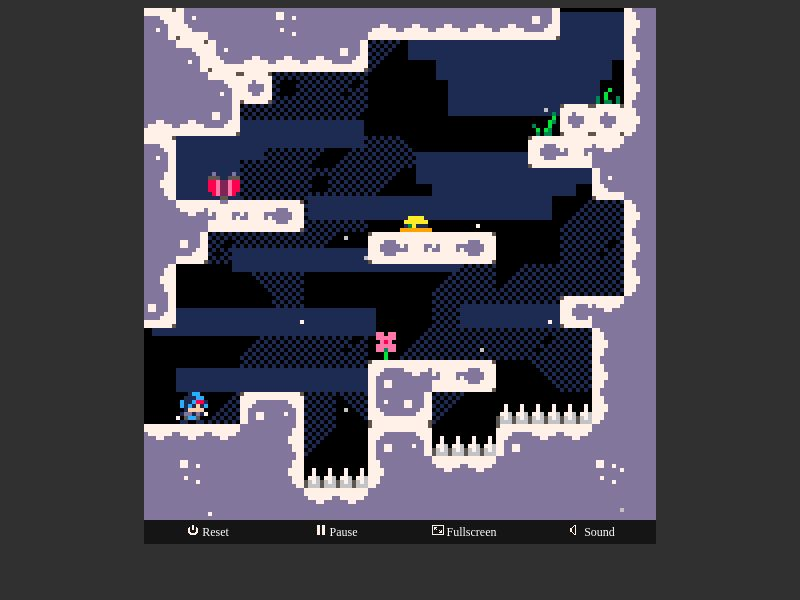

In [0]:
from IPython.display import display, clear_output, Image
import base64

for i in range(30):
  res = cdp.send('HeadlessExperimental.beginFrame',screenshot={'format':'jpeg'})#,noDisplayUpdates=True)
  if 'screenshotData' in res:
    clear_output()
    print(i)
    display(Image(base64.b64decode(res['screenshotData'])))

In [0]:
res = cdp.send('Page.captureScreenshot')
if 'data' in res:
  display(Image(res['data']))

WebSocketTimeoutException: ignored

In [0]:
res = cdp.send('Target.getTargets')
print(res)
for target in res['targetInfos']:
    pass
    #cdp.send('Target.closeTarget',targetId=target['targetId'])

{'targetInfos': [{'targetId': 'F23CED5BEC830C81262F9578F3B18788', 'type': 'page', 'title': 'PICO-8 Cartridge', 'url': 'https://v6p9d9t4.ssl.hwcdn.net/html/1379043/index.html', 'attached': True, 'browserContextId': 'AF1258F692FC50ABCDFF7A5FA2BFA8F8'}, {'targetId': 'EF87A5A12D5298CED6B873F385C67074', 'type': 'page', 'title': 'about:blank', 'url': 'about:blank', 'attached': False, 'browserContextId': 'AF1258F692FC50ABCDFF7A5FA2BFA8F8'}]}
